ADF Statistic: -4.721559963161231
p-value: 7.664549812957434e-05
Stationary


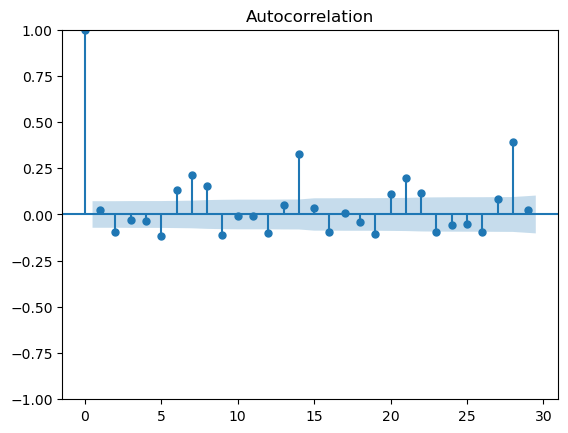

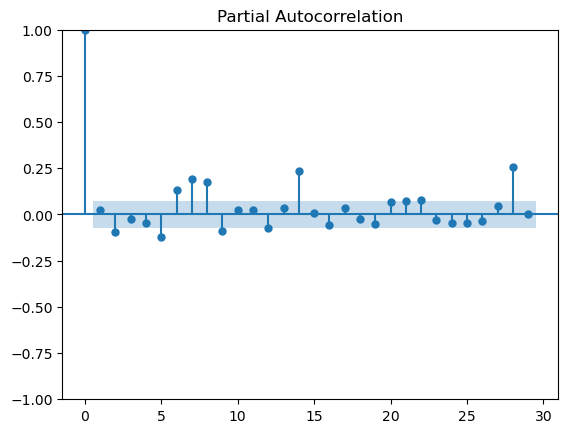

c:\Users\Dhananjay R\OneDrive - Zillion Technologies Inc\Apps\anaconda1\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Dhananjay R\OneDrive - Zillion Technologies Inc\Apps\anaconda1\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Dhananjay R\OneDrive - Zillion Technologies Inc\Apps\anaconda1\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Dhananjay R\OneDrive - Zillion Technologies Inc\Apps\anaconda1\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates

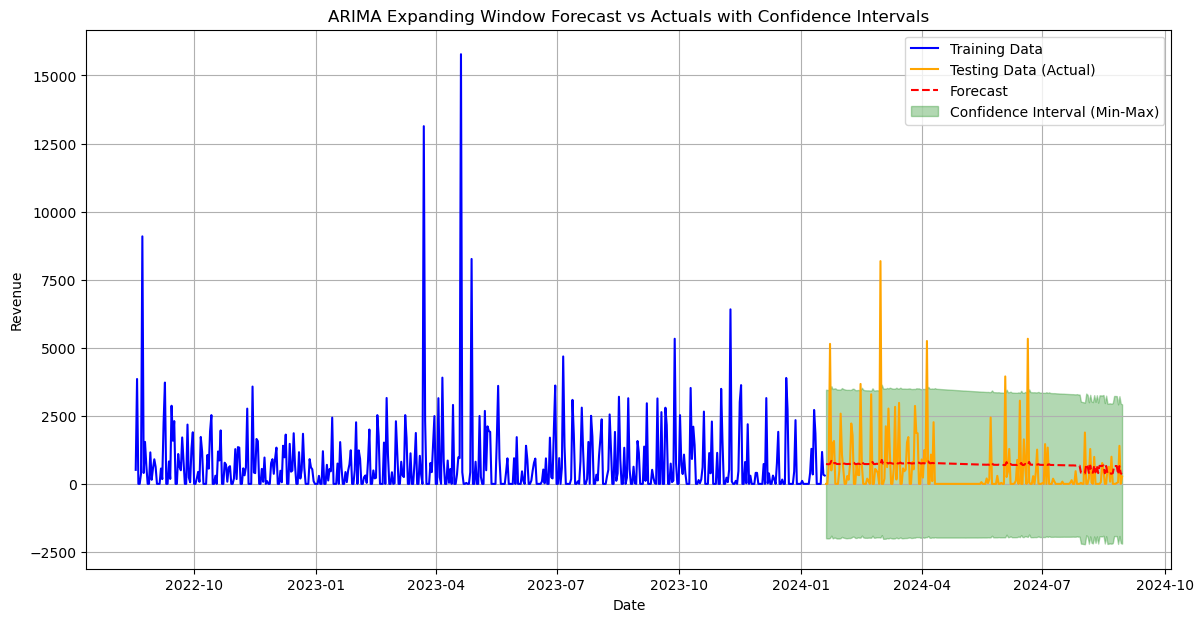

Mean Absolute Error (MAE): 771.00
Mean Squared Error (MSE): 1177239.67
Root Mean Squared Error (RMSE): 1085.01
Forecast results saved to 'Revenue_forecast_ARIMA_Dynamic.csv'.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Function to check stationarity
def check_stationarity(timeseries, significance_level=0.05):
    """
    Perform the Augmented Dickey-Fuller test to check stationarity.
    """
    result = adfuller(timeseries, autolag='AIC')
    p_value = result[1]
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {p_value}")
    return p_value < significance_level  # Return True if stationary

# Load the dataset
def load_and_prepare_data(filepath, time_column, target_column):
    """
    Load data and set it up for time series analysis.
    """
    data = pd.read_csv(filepath)
    data[time_column] = pd.to_datetime(data[time_column])
    data.set_index(time_column, inplace=True)
    data.sort_index(inplace=True)
    return data[target_column]

# Plot ACF and PACF
def plot_acf_pacf(series):
    """
    Plot ACF and PACF for the series.
    """
    plot_acf(series)
    plot_pacf(series)
    plt.show()

# Expanding window ARIMA forecast
def arima_expanding_window_forecast(series, initial_train_size, p, d, q):
    """
    Perform expanding window ARIMA forecasting.
    """
    test_size = len(series) - initial_train_size
    actuals, predictions, lower_bounds, upper_bounds = [], [], [], []

    for i in range(test_size):
        train = series.iloc[: initial_train_size + i]
        test = series.iloc[initial_train_size + i : initial_train_size + i + 1]

        model = ARIMA(train, order=(p, d, q))
        arima_fit = model.fit()

        forecast = arima_fit.get_forecast(steps=1)
        forecast_mean = forecast.predicted_mean.iloc[0]
        forecast_ci = forecast.conf_int()

        actuals.append(test.values[0])
        predictions.append(forecast_mean)
        lower_bounds.append(forecast_ci.iloc[0, 0])  # Lower CI
        upper_bounds.append(forecast_ci.iloc[0, 1])  # Upper CI

    comparison_df = pd.DataFrame({
        "Actual": actuals,
        "Predicted": predictions,
        "Lower_CI": lower_bounds,
        "Upper_CI": upper_bounds
    }, index=series.index[initial_train_size:])

    return comparison_df

# Plot results
def plot_forecast(series, train_size, comparison_df):
    """
    Plot the forecast results against actuals.
    """
    plt.figure(figsize=(14, 7))
    plt.plot(series.index[:train_size], series[:train_size], label="Training Data", color="blue")
    plt.plot(series.index[train_size:], comparison_df["Actual"], label="Testing Data (Actual)", color="orange")
    plt.plot(series.index[train_size:], comparison_df["Predicted"], label="Forecast", color="red", linestyle="--")
    plt.fill_between(series.index[train_size:], comparison_df["Lower_CI"], comparison_df["Upper_CI"], 
                     color="green", alpha=0.3, label="Confidence Interval (Min-Max)")
    plt.title("ARIMA Expanding Window Forecast vs Actuals with Confidence Intervals")
    plt.xlabel("Date")
    plt.ylabel("Revenue")
    plt.legend()
    plt.grid()
    plt.show()

# Main dynamic pipeline
def main(filepath, time_column, target_column, train_ratio=0.7, p=1, d=1, q=1):
    # Load and prepare data
    series = load_and_prepare_data(filepath, time_column, target_column)

    # Check stationarity
    is_stationary = check_stationarity(series)
    print("Stationary" if is_stationary else "Non-Stationary")

    # Plot ACF and PACF
    plot_acf_pacf(series)

    # Calculate initial train size
    train_size = int(len(series) * train_ratio)

    # Perform ARIMA Expanding Window Forecast
    comparison_df = arima_expanding_window_forecast(series, train_size, p, d, q)

    # Plot results
    plot_forecast(series, train_size, comparison_df)

    # Calculate metrics
    mae = mean_absolute_error(comparison_df["Actual"], comparison_df["Predicted"])
    mse = mean_squared_error(comparison_df["Actual"], comparison_df["Predicted"])
    rmse = np.sqrt(mse)

    # Print metrics
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Mean Squared Error (MSE): {mse:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

    # Save results to a CSV
    comparison_df.to_csv("Revenue_forecast_ARIMA_Dynamic.csv", index=False)
    print("Forecast results saved to 'Revenue_forecast_ARIMA_Dynamic.csv'.")

# Run the dynamic pipeline
if __name__ == "__main__":
    FILEPATH = r"C:\upi_data\transactions_single_account.csv"
    TIME_COLUMN = "transaction_date"
    TARGET_COLUMN = "total_revenue"
    main(FILEPATH, TIME_COLUMN, TARGET_COLUMN)
